In [2]:
import numpy as np
import matplotlib.pyplot as plt
from oetils.plotting import init_plotting
from tqdm.notebook import trange

In [3]:
W = init_plotting()

---

In [4]:
# MDP and policy setup
P = np.zeros((7, 2, 7))    # s, a, s'
P[:, 0] = 1 / 7
P[:, 1, -1] = 1
gamma = 0.99
beta = np.r_[6/7, 1/7]
pi = np.r_[0, 1]

In [5]:
def x(s):
    x = np.zeros(8)
    if s < 6:
        x[s] = 2
        x[-1] = 1
    else:
        x[s] = 1
        x[-1] = 2
    return x

In [6]:
w = np.ones(8)
w[-2] = 10
alpha = 0.01

In [18]:
T = 10_000

# Semi-gradient Off-policy DP
ws = np.zeros((T, 8))
ws[0] = w
for i in trange(1, T):
    ws[i] = ws[i - 1] + alpha/7*sum(
        (sum(pi[a]*sum(P[s, a, s_] * gamma * x(s_)@ws[i - 1] for s_ in range(7)) for a in range(2))
         - x(s)@ws[i - 1]) * x(s) for s in range(7))
w_dp_off = ws

# Semi-gradient Off-policy TD(0)
N = 1
w_td_off = np.zeros((T, 8))
for i in range(N):
    rng = np.random.default_rng(i)
    ws = np.zeros((T, 8))
    ws[0] = w
    s = rng.choice(7)
    for i in trange(1, T):
        a = rng.choice(2, p=beta)
        s_ = rng.choice(7, p=P[s, a])
        rho = pi[a] / beta[a]
        ws[i] = ws[i - 1] + alpha * rho * (gamma*x(s_)@ws[i - 1] - x(s)@ws[i - 1]) * x(s)
        s = s_
    w_td_off += ws
w_td_off /= N

T = 100_000

# Semi-gradient On-policy DP
ws = np.zeros((T, 8))
ws[0] = w
for i in trange(1, T):
    ws[i] = ws[i - 1] + alpha/7*sum(
        (sum(beta[a]*sum(P[s, a, s_] * gamma * x(s_)@ws[i - 1] for s_ in range(7)) for a in range(2))
         - x(s)@ws[i - 1]) * x(s) for s in range(7))
w_dp_on = ws

# Semi-gradient On-policy TD(0)
N = 1
w_td_on = np.zeros((T, 8))
for i in range(N):
    rng = np.random.default_rng(i)
    ws = np.zeros((T, 8))
    ws[0] = w
    s = rng.choice(7)
    for i in trange(1, T):
        a = rng.choice(2, p=beta)
        s_ = rng.choice(7, p=P[s, a])
        ws[i] = ws[i - 1] + alpha * (gamma*x(s_)@ws[i - 1] - x(s)@ws[i - 1]) * x(s)
        s = s_
    w_td_on += ws
w_td_on /= N

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

  0%|          | 0/99999 [00:00<?, ?it/s]

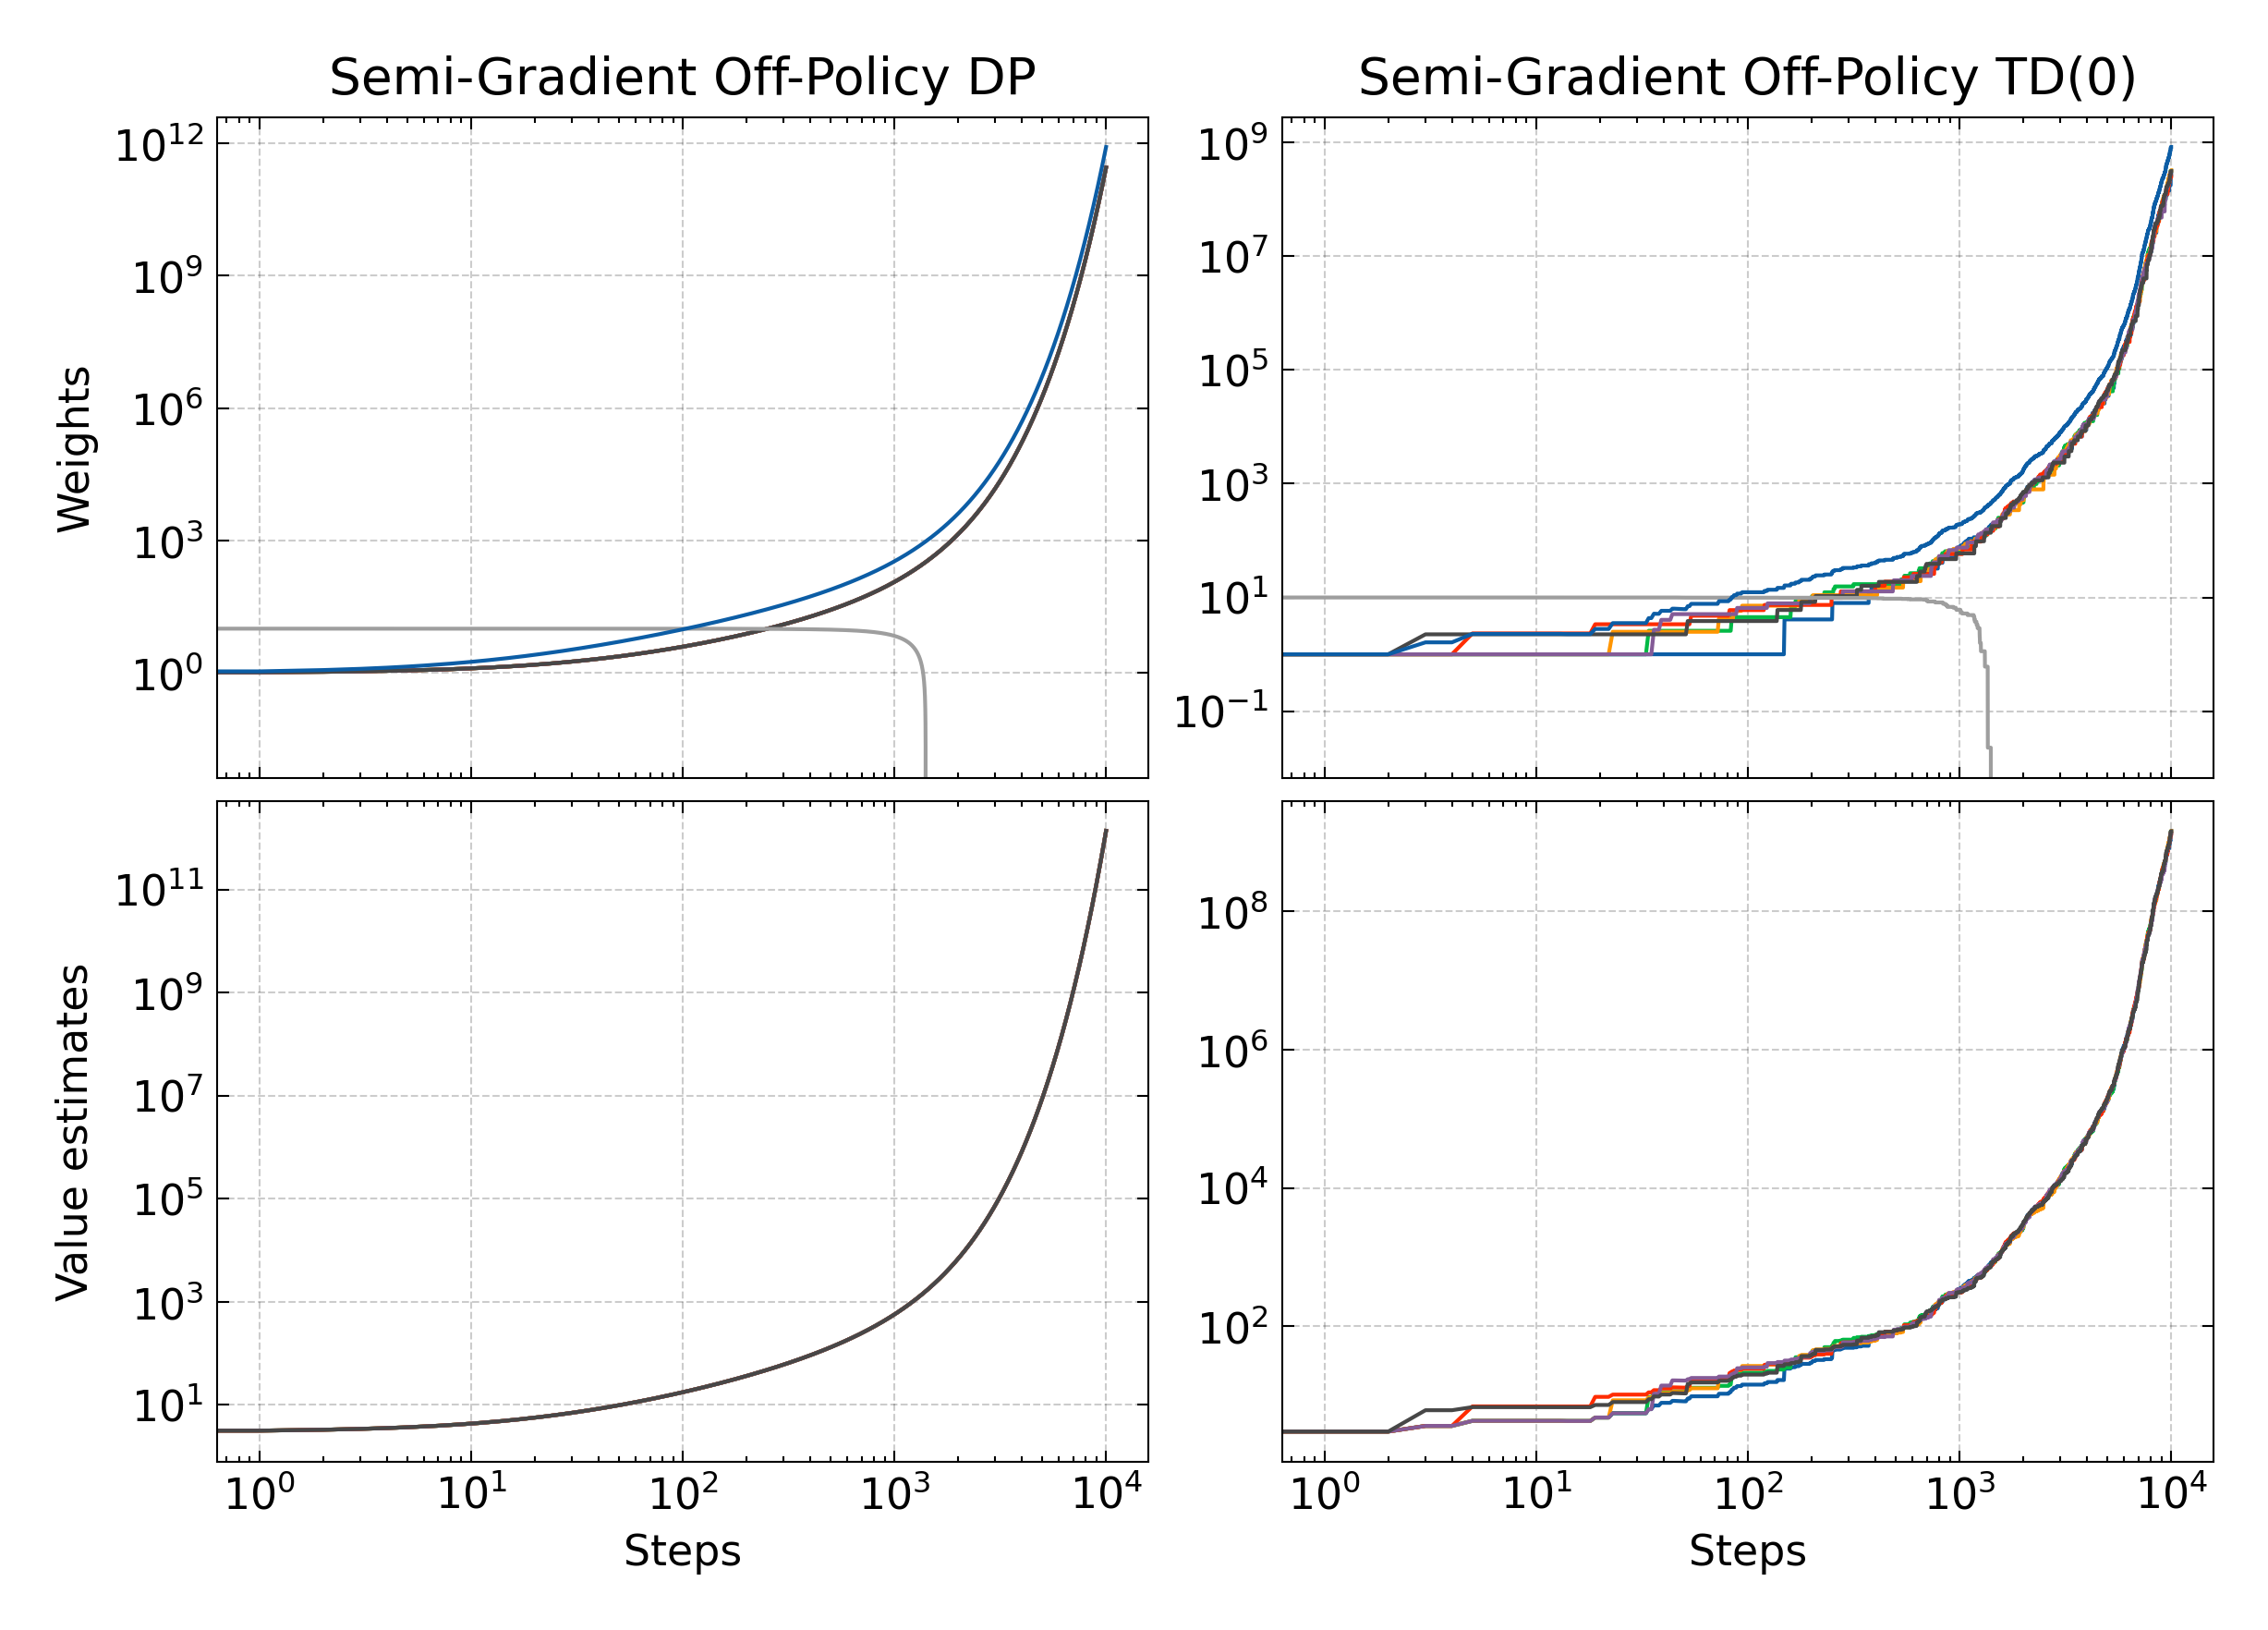

In [25]:
T = 10_000
fig, ax = plt.subplots(2, 2, sharex=True)
ax[0, 0].set_title("Semi-Gradient Off-Policy DP")
ax[0, 1].set_title("Semi-Gradient Off-Policy TD(0)")
ax[0, 0].set_ylabel("Weights")
ax[1, 0].set_ylabel("Value estimates")
ax[-1, 0].set_xlabel("Steps")
ax[-1, 1].set_xlabel("Steps")
ax[0, 0].loglog(np.arange(T), w_dp_off)
ax[0, 1].loglog(np.arange(T), w_td_off)
ax[1, 0].loglog(np.arange(T), w_dp_off @ np.array([x(s) for s in range(6)]).T)
ax[1, 1].loglog(np.arange(T), w_td_off @ np.array([x(s) for s in range(6)]).T)
plt.show()

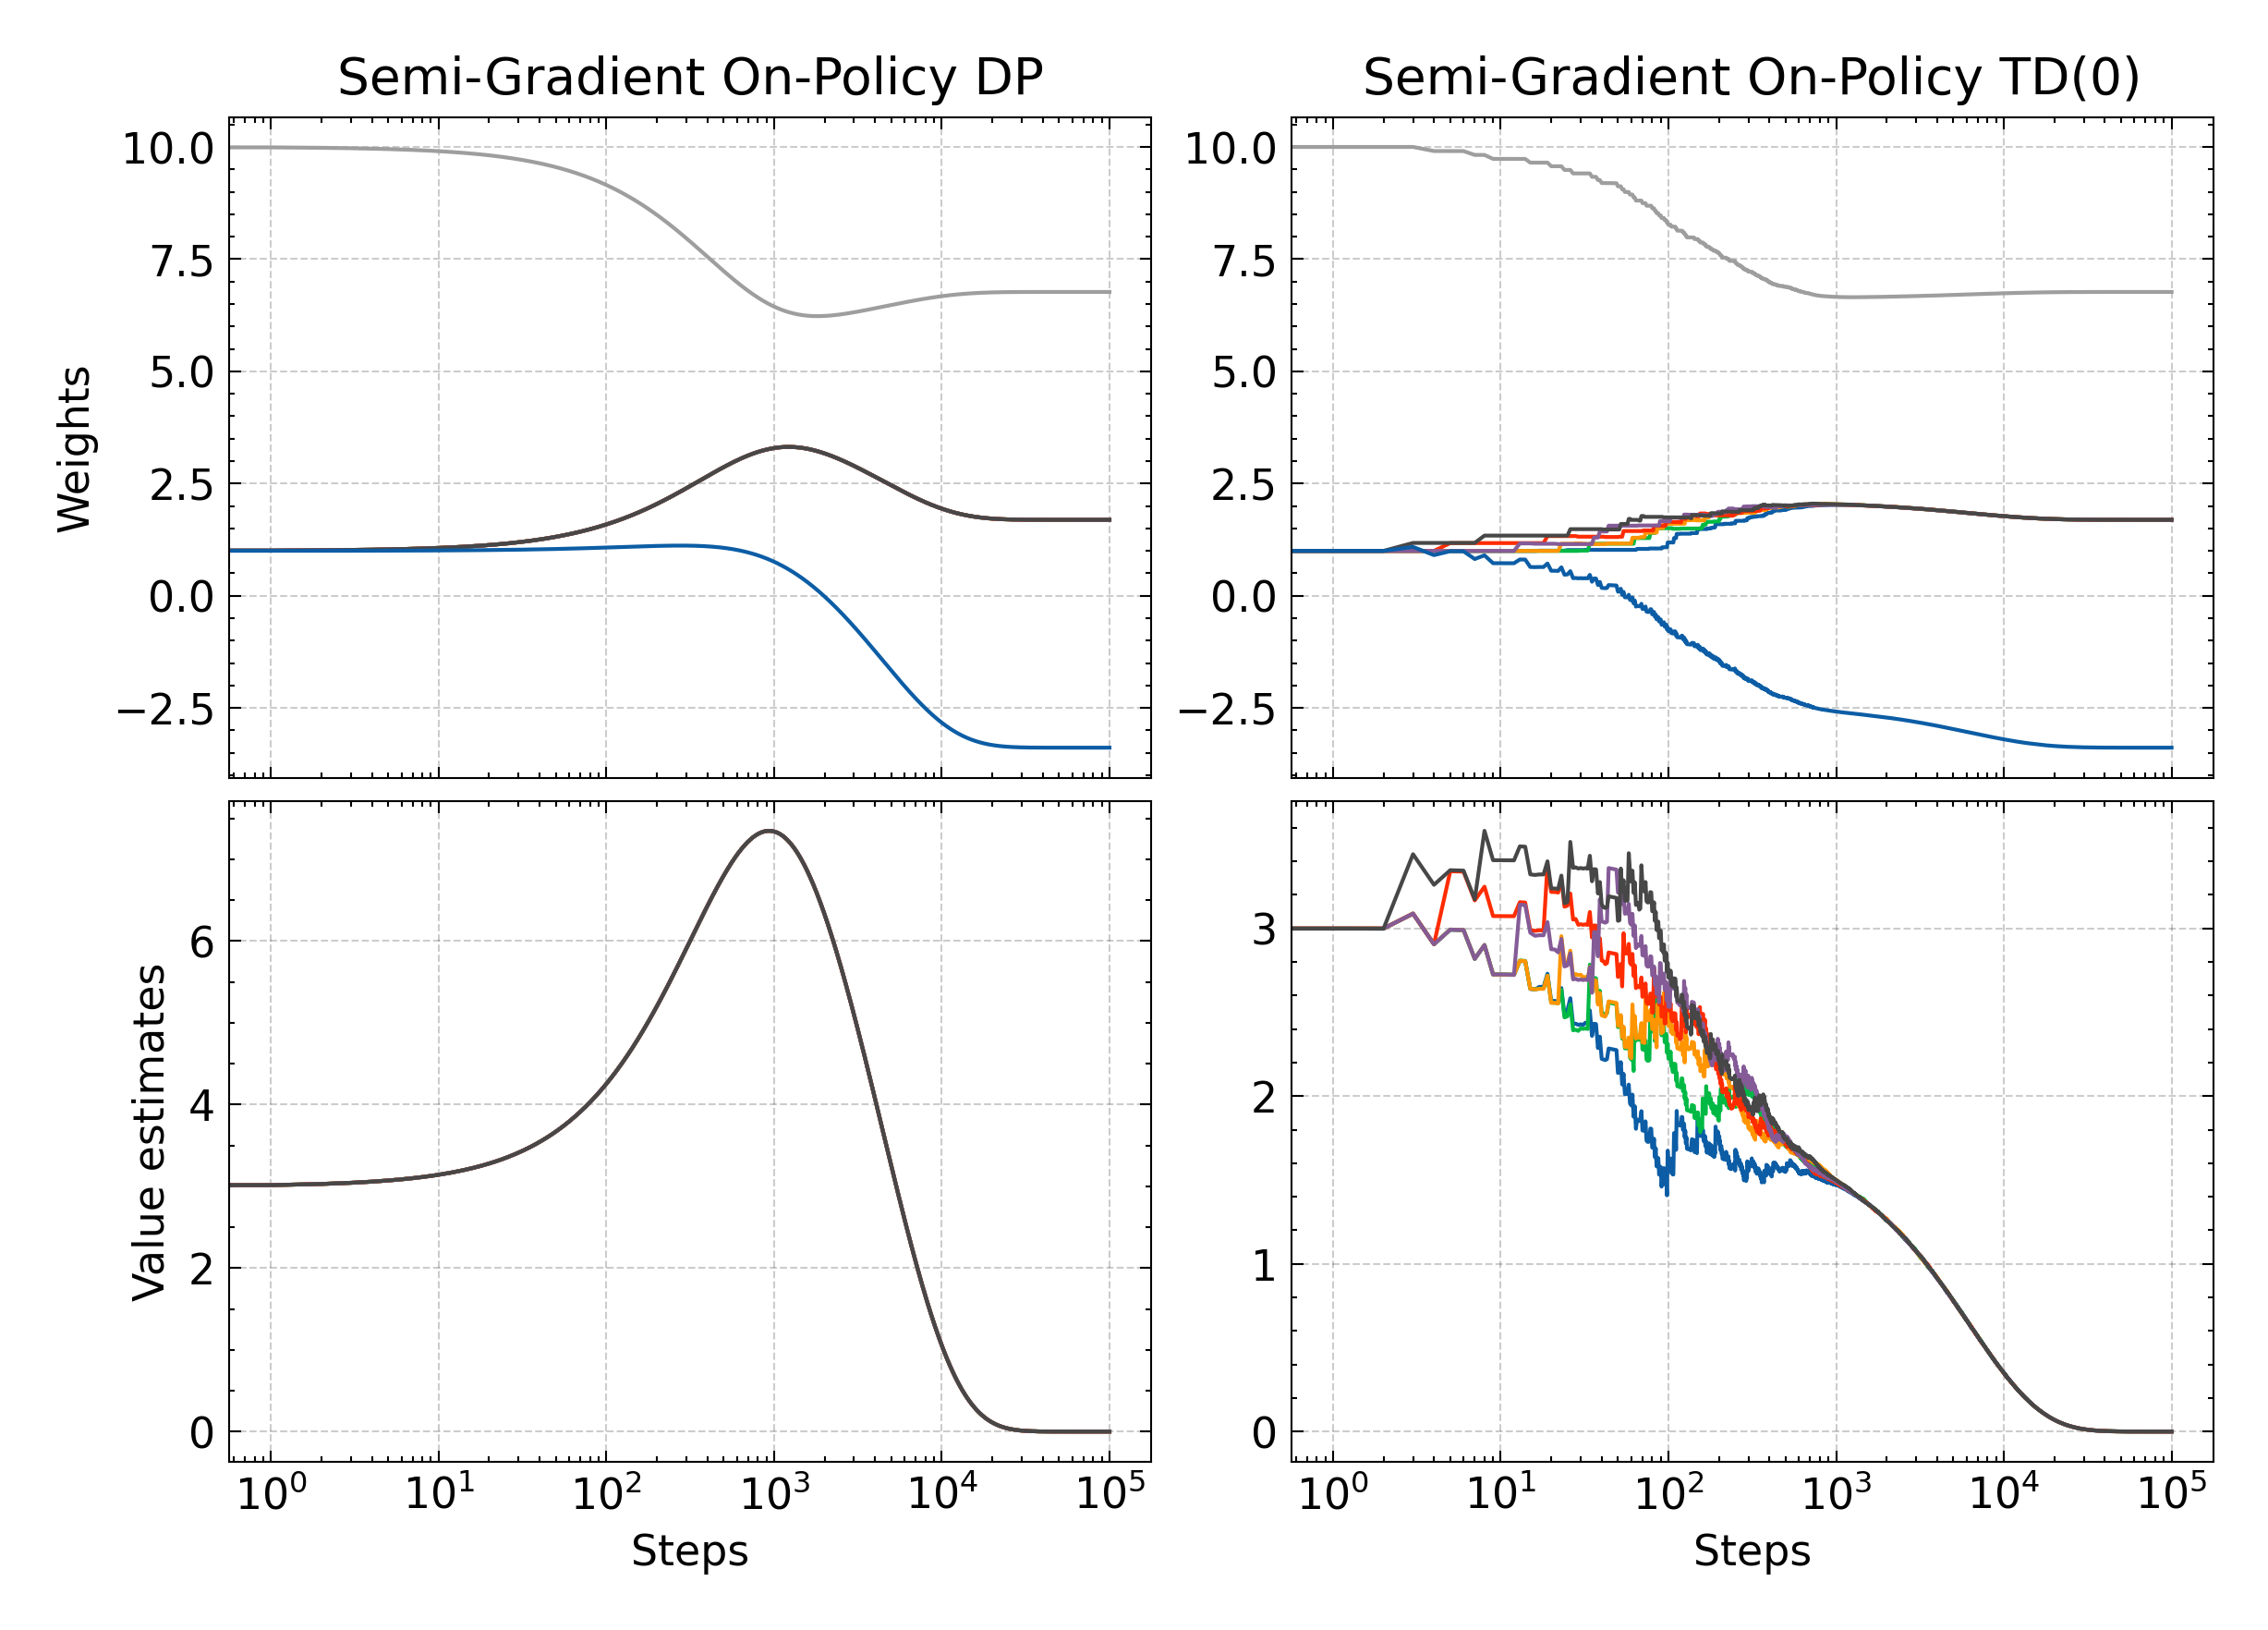

In [20]:
T = 100_000
fig, ax = plt.subplots(2, 2, sharex=True)
ax[0, 0].set_title("Semi-Gradient On-Policy DP")
ax[0, 1].set_title("Semi-Gradient On-Policy TD(0)")
ax[0, 0].set_ylabel("Weights")
ax[1, 0].set_ylabel("Value estimates")
ax[-1, 0].set_xlabel("Steps")
ax[-1, 1].set_xlabel("Steps")
ax[0, 0].set_xscale('log')
ax[0, 0].plot(np.arange(T), w_dp_on)
ax[0, 1].plot(np.arange(T), w_td_on)
ax[1, 0].plot(np.arange(T), w_dp_on @ np.array([x(s) for s in range(6)]).T)
ax[1, 1].plot(np.arange(T), w_td_on @ np.array([x(s) for s in range(6)]).T)
plt.show()

In [27]:
def x(s, a):
    x = np.zeros(15)
    if a == 1:
        if s < 6:
            x[s] = 2
            x[-1] = 1
        else:
            x[s] = 1
            x[-1] = 2
    else:
        x[8 + s] = 1
    return x

w = np.ones(15)
alpha = 0.01

In [46]:
T = 10_000

# Semi-gradient Q-learning (Eq. 11.5)
N = 1
w_q = np.zeros((T, 15))
for i in range(N):
    rng = np.random.default_rng(i)
    ws = np.zeros((T, 15))
    ws[0] = w
    s = rng.choice(7)
    for i in trange(1, T):
        a = rng.choice(2, p=beta)
        s_ = rng.choice(7, p=P[s, a])
        ws[i] = ws[i - 1] + alpha * (gamma*max(x(s_, a_)@ws[i - 1] for a_ in range(2)) - x(s, a)@ws[i - 1]) * x(s, a)
        s = s_
    w_q += ws
w_q /= N

T = 1_000_000

# Semi-gradient Sarsa
N = 1
w_s = np.zeros((T, 15))
for i in range(N):
    rng = np.random.default_rng(i)
    ws = np.zeros((T, 15))
    ws[0] = w
    s = rng.choice(7)
    a = rng.choice(2, p=beta)
    for i in trange(1, T):
        s_ = rng.choice(7, p=P[s, a])
        a_ = rng.choice(2, p=beta)
        ws[i] = ws[i - 1] + alpha * (gamma*x(s_, a_)@ws[i - 1] - x(s, a)@ws[i - 1]) * x(s, a)
        s, a = s_, a_
    w_s += ws
w_s /= N

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 0/999999 [00:00<?, ?it/s]

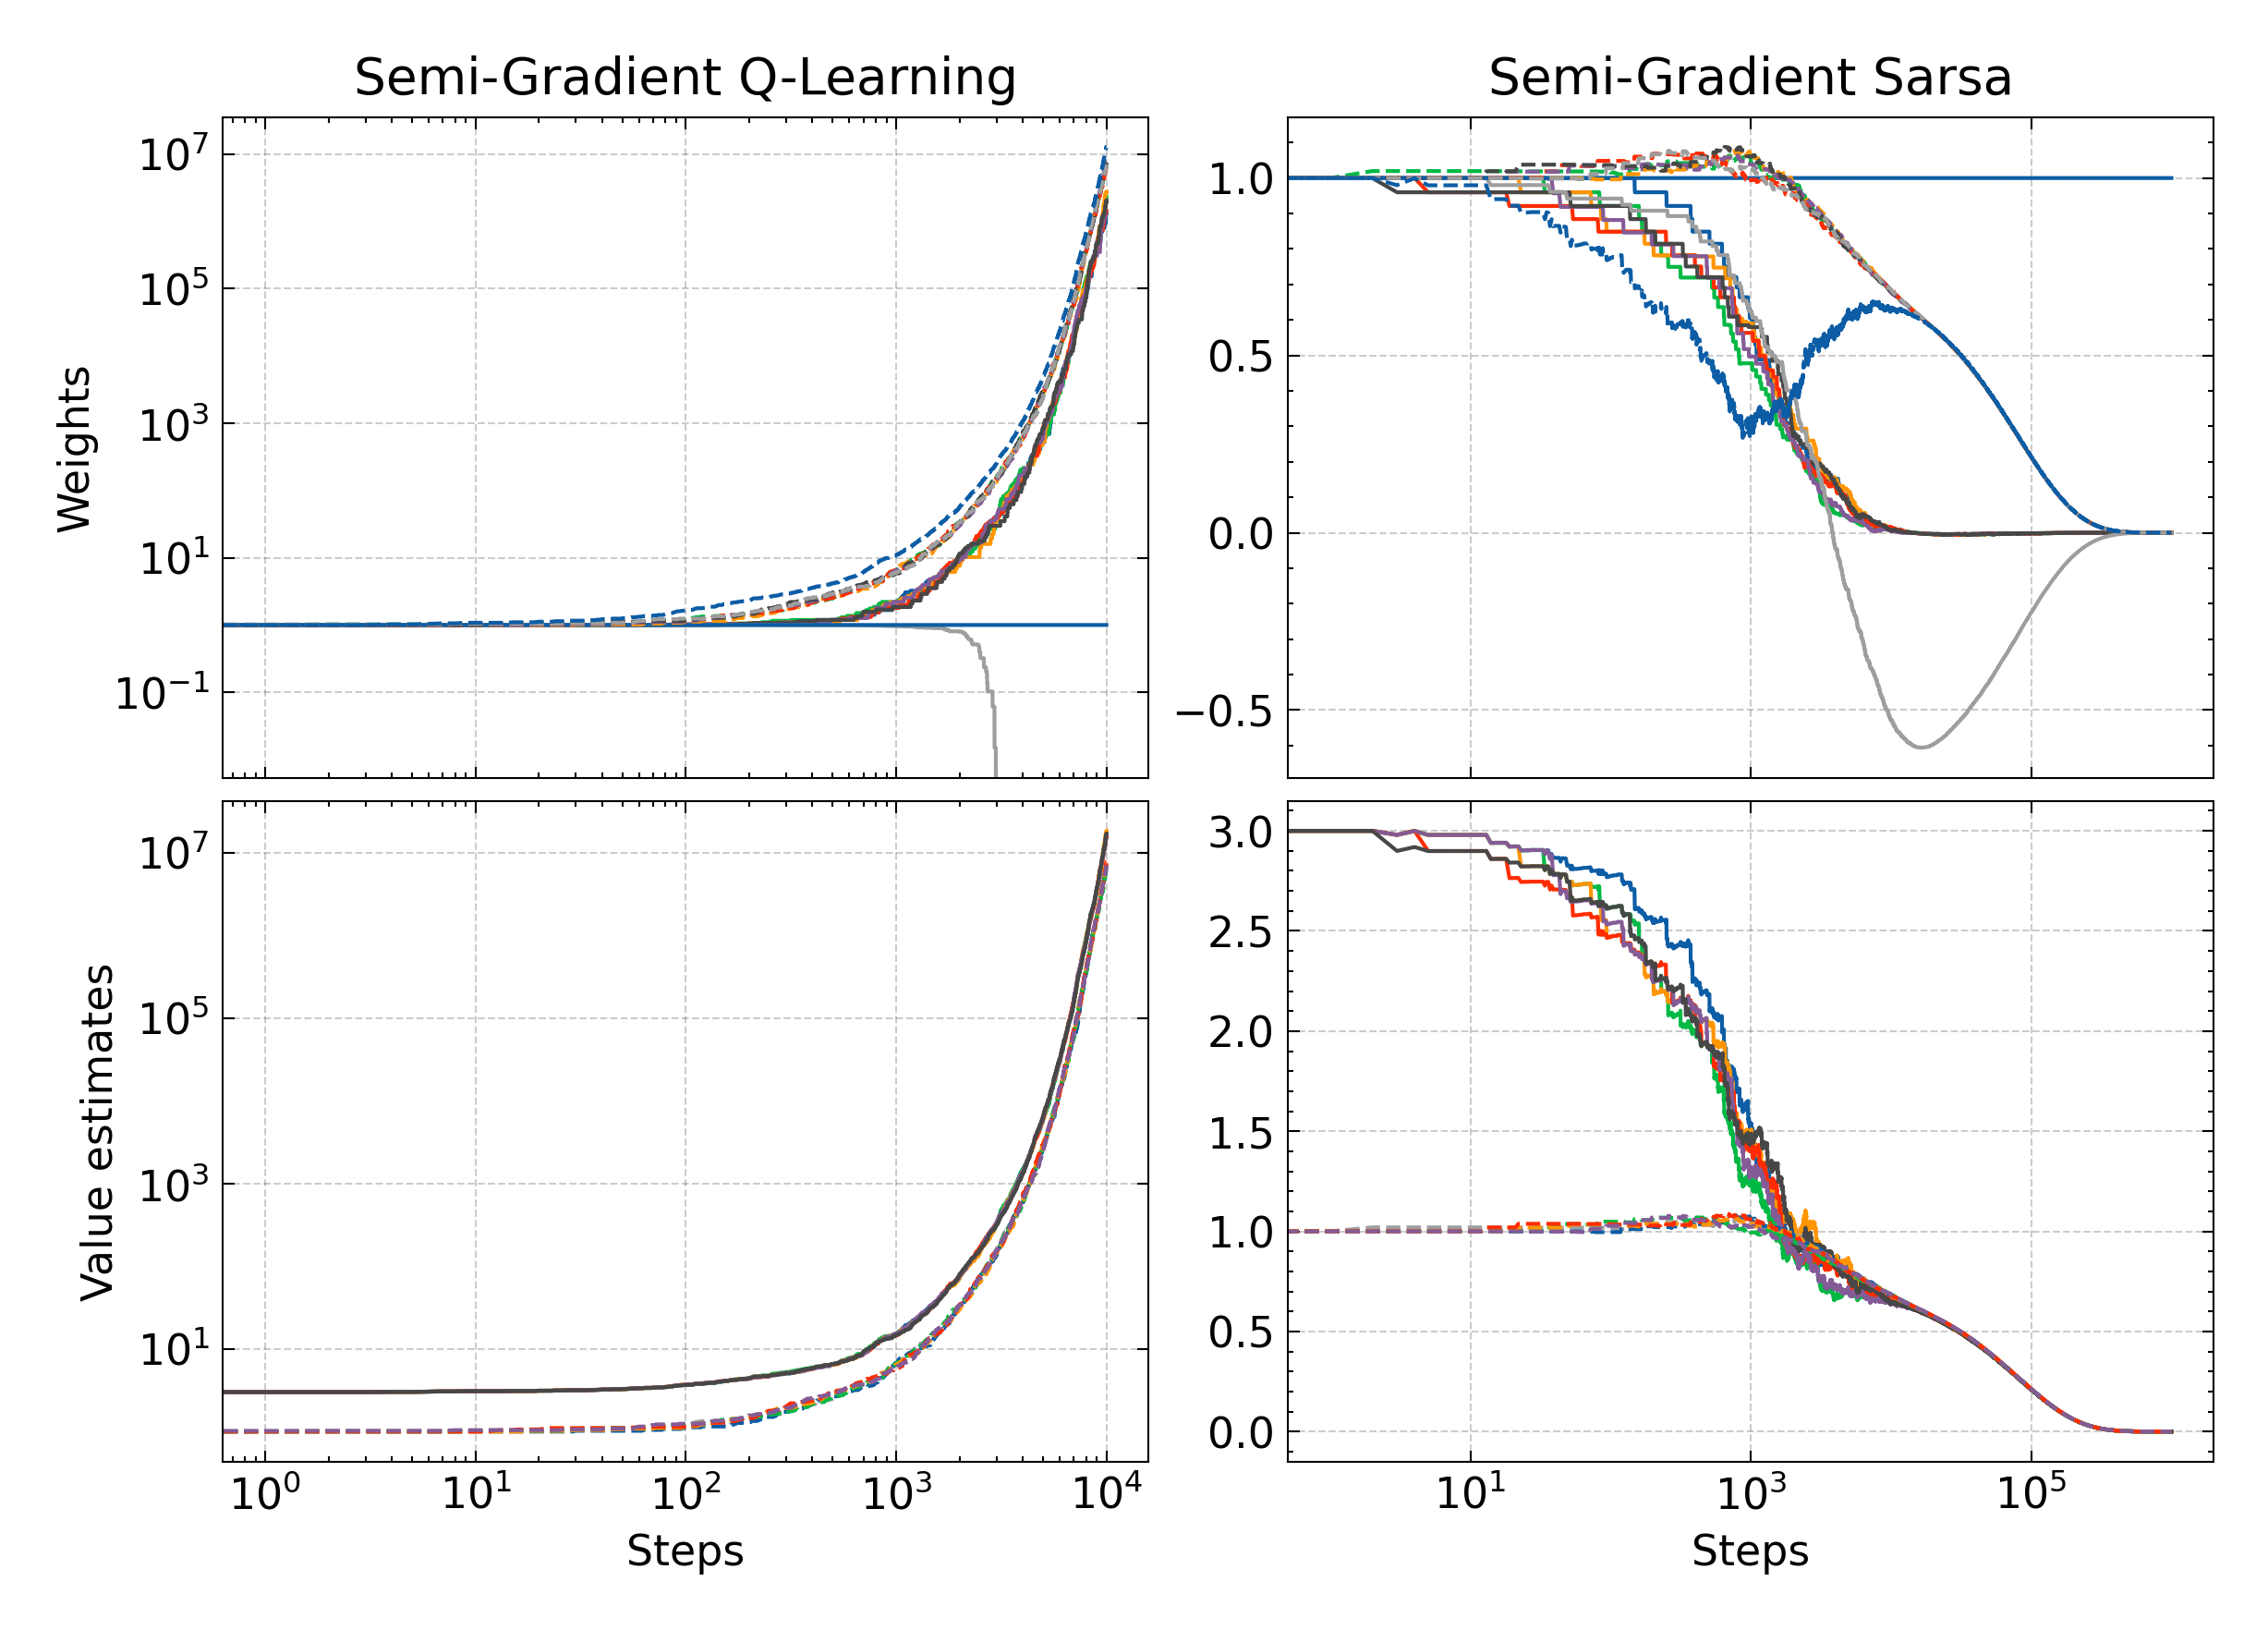

In [47]:
T1 = 10_000
T2 = 1_000_000
fig, ax = plt.subplots(2, 2, sharex='col')
ax[0, 0].set_title("Semi-Gradient Q-Learning")
ax[0, 1].set_title("Semi-Gradient Sarsa")
ax[0, 0].set_ylabel("Weights")
ax[1, 0].set_ylabel("Value estimates")
ax[-1, 0].set_xlabel("Steps")
ax[-1, 1].set_xlabel("Steps")
ax[0, 0].loglog(np.arange(T1), w_q[:, :8])
ax[0, 0].loglog(np.arange(T1), w_q[:, 8:], ls='--')
ax[0, 1].semilogx(np.arange(T2), w_s[:, :8])
ax[0, 1].semilogx(np.arange(T2), w_s[:, 8:], ls='--')
ax[1, 0].loglog(np.arange(T1), w_q @ np.array([x(s, 1) for s in range(6)]).T)
ax[1, 0].loglog(np.arange(T1), w_q @ np.array([x(s, 0) for s in range(6)]).T, ls='--')
ax[1, 1].semilogx(np.arange(T2), w_s @ np.array([x(s, 1) for s in range(6)]).T)
ax[1, 1].semilogx(np.arange(T2), w_s @ np.array([x(s, 0) for s in range(6)]).T, ls='--')
plt.show()